# Plantilla: Proyecto
## Tema 2: Clasificación de barrios en función de su tipología.
Documento plantilla para el proyecto con los imports de las librerias más importantes.

In [1]:
import nltk                      # Natural Language Toolkit
import scrapy                    # Web scraping  
import requests                  # HTTP requests
import selenium                  # Web automation
import numpy as np               # Numerical computing
import pandas as pd              # Data manipulation
import seaborn as sns            # Data visualization
import tensorflow as tf          # Machine learning
import matplotlib.pyplot as plt  # Data visualization

from bs4 import BeautifulSoup    # HTML parsing

In [2]:
# Carga la página P.19.1 del documento \docs_Carlos\Distritos23.xlsx. Las primeras 10 líneas son de encabezado.

%pip install openpyxl


Note: you may need to restart the kernel to use updated packages.


In [3]:
#

df_seguridad = pd.read_excel('docs_Carlos/Distritos23.xlsx', sheet_name=' P.19.1', header=8)
# cambiar el nombre de la primera columna que hace de header a 'Distrito':
df_seguridad.rename(columns={'Unnamed: 0':'Distrito'}, inplace=True)
df_seguridad.rename(columns={'Unnamed: 15':'Seguridad'}, inplace=True)
df_seguridad.rename(columns={'Unnamed: 16':'Desviación'}, inplace=True)
df_seguridad.rename(columns={'Unnamed: 17':'Mediana'}, inplace=True)
#eliminar las columans 1 a 14
df_seguridad = df_seguridad.drop(df_seguridad.columns[1:15], axis=1)
df_seguridad = df_seguridad.drop(df_seguridad.columns[2:], axis=1)

df_seguridad['Seguridad'] = df_seguridad['Seguridad']/10
df_seguridad.head(19)


,Distrito,Seguridad
0,Total,0.675763
1,1. Ciutat Vella,0.715789
2,2. l'Eixample,0.741270
3,3. Extramurs,0.754198
4,4. Campanar,0.699153
5,5. la Saïdia,0.535156
6,6. el Pla del Real,0.745299
7,7. l'Olivereta,0.668462
8,8. Patraix,0.734559
9,9. Jesús,0.672932


In [4]:
df_discrimin = pd.read_excel('docs_Carlos/Distritos23.xlsx', sheet_name=' P.31.1', header=8)
# cambiar el nombre de la primera columna que hace de header a 'Distrito':
df_discrimin.rename(columns={'Unnamed: 0':'Distrito'}, inplace=True)
df_discrimin.rename(columns={' Sí':'Discriminacion'}, inplace=True)
#elimino la última columna que no tiene datos
df_discrimin = df_discrimin.iloc[:, :-1]
df_discrimin = df_discrimin.drop(df_discrimin.columns[2:], axis=1)
df_discrimin['Discriminacion'] = df_discrimin['Discriminacion']/100
df_discrimin.head(19)


,Distrito,Discriminacion
0,Total,0.135579
1,1. Ciutat Vella,0.149123
2,2. l'Eixample,0.150794
3,3. Extramurs,0.152672
4,4. Campanar,0.152542
5,5. la Saïdia,0.109375
6,6. el Pla del Real,0.136752
7,7. l'Olivereta,0.215385
8,8. Patraix,0.139706
9,9. Jesús,0.067669


In [5]:
df_convivenc = pd.read_excel('docs_Carlos/Distritos23.xlsx', sheet_name=' P.19.1', header=8)
# cambiar el nombre de la primera columna que hace de header a 'Distrito':
df_convivenc.rename(columns={'Unnamed: 0':'Distrito'}, inplace=True)
df_convivenc.rename(columns={'Unnamed: 15':'Convivencia'}, inplace=True)
df_convivenc.rename(columns={'Unnamed: 16':'Desviación'}, inplace=True)
df_convivenc.rename(columns={'Unnamed: 17':'Mediana'}, inplace=True)

#eliminar las columans 1 a 14
df_convivenc = df_convivenc.drop(df_convivenc.columns[1:15], axis=1)
df_convivenc = df_convivenc.drop(df_convivenc.columns[2:], axis=1)
df_convivenc['Convivencia'] = df_convivenc['Convivencia']/10
df_convivenc.head(19)


,Distrito,Convivencia
0,Total,0.675763
1,1. Ciutat Vella,0.715789
2,2. l'Eixample,0.741270
3,3. Extramurs,0.754198
4,4. Campanar,0.699153
5,5. la Saïdia,0.535156
6,6. el Pla del Real,0.745299
7,7. l'Olivereta,0.668462
8,8. Patraix,0.734559
9,9. Jesús,0.672932


In [6]:
df_extranjer = pd.read_excel('docs_Carlos/Distritos23.xlsx', sheet_name=' P.36', header=7)
# cambiar el nombre de la primera columna que hace de header a 'Distrito':
df_extranjer.rename(columns={'Unnamed: 0':'Distrito'}, inplace=True)
# añadir una columna que sea: "true Valencia" y condensar en ella las columnas 2 y 3 en una sola que sume los valores por fila
df_extranjer['Españoles'] = df_extranjer.iloc[:, 1] + df_extranjer.iloc[:, 2] + df_extranjer.iloc[:, 3] + df_extranjer.iloc[:, 4]
# añadir una columna que sea: "Extranjeros" y condensar en ella las columnas 4, 5 y 6 en una sola que sume los valores por fila
df_extranjer['Extranjeros'] = df_extranjer.iloc[:, 5] 
# Eliminar las columnas 2 a 8
df_extranjer = df_extranjer.drop(df_extranjer.columns[1:9], axis=1)
#eliminar columna 1 y 3
df_extranjer = df_extranjer.drop(df_extranjer.columns[1], axis=1)
df_extranjer['Extranjeros'] = df_extranjer['Extranjeros']/100
df_extranjer.head(19)


,Distrito,Extranjeros
0,Total,0.183847
1,1. Ciutat Vella,0.140351
2,2. l'Eixample,0.055556
3,3. Extramurs,0.152672
4,4. Campanar,0.177966
5,5. la Saïdia,0.242188
6,6. el Pla del Real,0.000000
7,7. l'Olivereta,0.230769
8,8. Patraix,0.308824
9,9. Jesús,0.218045


In [7]:
df_op_politi  = pd.read_excel('docs_Carlos/Distritos23.xlsx', sheet_name=' P.37', header=8)
# cambiar el nombre de la primera columna que hace de header a 'Distrito':
df_op_politi.rename(columns={'Unnamed: 0':'Distrito'}, inplace=True)
df_op_politi.rename(columns={'Unnamed: 14':'Política'}, inplace=True)
df_op_politi.rename(columns={'Unnamed: 15':'Desviación'}, inplace=True)
df_op_politi.rename(columns={'Unnamed: 16':'Mediana'}, inplace=True)
#eliminar las columans 1 a 13
df_op_politi = df_op_politi.drop(df_op_politi.columns[1:14], axis=1)
df_op_politi = df_op_politi.drop(df_op_politi.columns[2:], axis=1)
df_op_politi['Política'] = df_op_politi['Política']/10
df_op_politi.head(19)

,Distrito,Política
0,Total,0.534791
1,1. Ciutat Vella,0.593814
2,2. l'Eixample,0.638938
3,3. Extramurs,0.562037
4,4. Campanar,0.533708
5,5. la Saïdia,0.516071
6,6. el Pla del Real,0.724138
7,7. l'Olivereta,0.476106
8,8. Patraix,0.521774
9,9. Jesús,0.500000


In [8]:
df_s_laboral  = pd.read_excel('docs_Carlos/Distritos23.xlsx', sheet_name=' P.39', header=7)
# cambiar el nombre de la primera columna que hace de header a 'Distrito':
df_s_laboral.rename(columns={'Unnamed: 0':'Distrito'}, inplace=True)
# Remombrar la segunda columna como "Empleados" (acceder a ella por indice)
df_s_laboral.rename(columns={df_s_laboral.columns[1]:'Empleados'}, inplace=True)
df_s_laboral.rename(columns={' Estudiante':'Estudiantes'}, inplace=True)
# Crear columna Extra llamada "parados_b" que sea la suma de las columnas 2 y 3
df_s_laboral['Desempleados'] = df_s_laboral.iloc[:, 2] + df_s_laboral.iloc[:, 3]
#eliminar columnas 2 y 3
df_s_laboral = df_s_laboral.drop(df_s_laboral.columns[2:4], axis=1)
#eliminar columnas 3, 4 5 y 6
df_s_laboral = df_s_laboral.drop(df_s_laboral.columns[3:7], axis=1)
df_s_laboral['Desempleados'] = df_s_laboral['Desempleados']/100
df_s_laboral['Empleados'] = df_s_laboral['Empleados']/100
df_s_laboral['Estudiantes'] = df_s_laboral['Estudiantes']/100
df_s_laboral.head(19)


#df_extranjer['Españoles'] = df_extranjer.iloc[:, 1] + df_extranjer.iloc[:, 2]

,Distrito,Empleados,Estudiantes,Desempleados
0,Total,0.506947,0.081897,0.077091
1,1. Ciutat Vella,0.570175,0.166667,0.052632
2,2. l'Eixample,0.507937,0.087302,0.055556
3,3. Extramurs,0.534351,0.061069,0.053435
4,4. Campanar,0.516949,0.067797,0.059322
5,5. la Saïdia,0.492188,0.070312,0.078125
6,6. el Pla del Real,0.487179,0.273504,0.034188
7,7. l'Olivereta,0.507692,0.046154,0.092308
8,8. Patraix,0.470588,0.051471,0.095588
9,9. Jesús,0.481203,0.067669,0.090226


In [9]:
df_ingresos = pd.read_excel('docs_Carlos/Distritos23.xlsx', sheet_name=' P.43', header=8)
df_ingresos.rename(columns={'Unnamed: 0':'Distrito'}, inplace=True)

medias = [0, 250, 750, 1250, 2000, 3750, 6000]

# Calcular el valor esperado de los ingresos. Para cada fila, multiplicar cada valor de la columna [i] (a partir de la 1) por el valor de medias[i] y sumarlo
df_ingresos['Ingresos Mes'] = sum([df_ingresos.iloc[:, i] * medias[i]/100 for i in range(1, 7)])

#eliminar las columnas 1 a 10
df_ingresos = df_ingresos.drop(df_ingresos.columns[1:11], axis=1)

# cambiar el valor de la media de la fila 5 por 

df_ingresos.head(19)


,Distrito,Ingresos Mes
0,Total,1875.070412
1,1. Ciutat Vella,2741.228070
2,2. l'Eixample,1908.730159
3,3. Extramurs,2022.900763
4,4. Campanar,993.644068
5,5. la Saïdia,0.000000
6,6. el Pla del Real,2525.641026
7,7. l'Olivereta,2275.000000
8,8. Patraix,3200.367647
9,9. Jesús,1979.323308


In [10]:

df_ingresos_rel = df_ingresos.copy()
df_ingresos_rel['Ingresos Mes REL'] = df_ingresos_rel['Ingresos Mes']/10000
df_ingresos_rel.head(19)

,Distrito,Ingresos Mes,Ingresos Mes REL
0,Total,1875.070412,0.187507
1,1. Ciutat Vella,2741.228070,0.274123
2,2. l'Eixample,1908.730159,0.190873
3,3. Extramurs,2022.900763,0.202290
4,4. Campanar,993.644068,0.099364
5,5. la Saïdia,0.000000,0.000000
6,6. el Pla del Real,2525.641026,0.252564
7,7. l'Olivereta,2275.000000,0.227500
8,8. Patraix,3200.367647,0.320037
9,9. Jesús,1979.323308,0.197932


In [11]:
#exportar el dataframe df_ingresos a un archivo csv
df_ingresos.to_csv('docs_Carlos/df_ingresos.csv', index=False)


In [12]:
# Porcentaje de poblacción que lleva viviendo en el mismo distrito más de 5 años

df_permanencia = pd.read_excel('docs_Carlos/Distritos23.xlsx', sheet_name=' P.0', header=7)
df_permanencia.rename(columns={'Unnamed: 0':'Distrito'}, inplace=True)
df_permanencia.rename(columns={' Más de 5 años':'AntRes_5y'}, inplace=True)

#eliminar las columnas 1 a 10
df_permanencia = df_permanencia.drop(df_permanencia.columns[1:4], axis=1)
df_permanencia = df_permanencia.drop(df_permanencia.columns[2:], axis=1)
df_permanencia['AntRes_5y'] = df_permanencia['AntRes_5y']/100
df_permanencia



,Distrito,AntRes_5y
0,Total,0.765354
1,1. Ciutat Vella,0.684211
2,2. l'Eixample,0.857143
3,3. Extramurs,0.778626
4,4. Campanar,0.694915
5,5. la Saïdia,0.804688
6,6. el Pla del Real,0.649573
7,7. l'Olivereta,0.776923
8,8. Patraix,0.676471
9,9. Jesús,0.812030


In [13]:
df_satisfacc = pd.read_excel('docs_Carlos/Distritos23.xlsx', sheet_name=' P.3', header=8)
df_satisfacc.rename(columns={'Unnamed: 0':'Distrito'}, inplace=True)
df_satisfacc.rename(columns={'Unnamed: 15':'Satisfaccion'}, inplace=True)

df_satisfacc = df_satisfacc.drop(df_satisfacc.columns[1:15], axis=1)
df_satisfacc = df_satisfacc.drop(df_satisfacc.columns[2:], axis=1)
df_satisfacc['Satisfaccion'] = df_satisfacc['Satisfaccion']/10
df_satisfacc.head(19)


,Distrito,Satisfaccion
0,Total,0.821059
1,1. Ciutat Vella,0.791228
2,2. l'Eixample,0.796032
3,3. Extramurs,0.835115
4,4. Campanar,0.845763
5,5. la Saïdia,0.896094
6,6. el Pla del Real,0.747863
7,7. l'Olivereta,0.845385
8,8. Patraix,0.757353
9,9. Jesús,0.841353


In [14]:
df_pr_situ_econo = pd.read_excel('docs_Carlos/Distritos23.xlsx', sheet_name='P.6', header=7)

df_pr_situ_econo.rename(columns={'Unnamed: 0':'Distrito'}, inplace=True)
#cambiar nombre de la columna 1 a 'Buena Situación económica'
df_pr_situ_econo.rename(columns={'La mala situación económica y la inflación':'Precariedad Econo'}, inplace=True)
df_pr_situ_econo = df_pr_situ_econo.drop(df_pr_situ_econo.columns[2:], axis=1)

df_pr_situ_econo['Precariedad Econo'] = df_pr_situ_econo['Precariedad Econo']/100
df_pr_situ_econo.head(19)

,Distrito,Precariedad Econo
0,Total,0.166817
1,1. Ciutat Vella,0.149123
2,2. l'Eixample,0.119048
3,3. Extramurs,0.091603
4,4. Campanar,0.161017
5,5. la Saïdia,0.265625
6,6. el Pla del Real,0.085470
7,7. l'Olivereta,0.184615
8,8. Patraix,0.117647
9,9. Jesús,0.180451


In [15]:
df_pr_acceso_casa = pd.read_excel('docs_Carlos/Distritos23.xlsx', sheet_name='P.6', header=7)

df_pr_acceso_casa.rename(columns={'Unnamed: 0':'Distrito'}, inplace=True)
df_pr_acceso_casa.rename(columns={'El acceso a la vivienda / escasa oferta / precio alquiler':'Prob Vivienda'}, inplace=True)
df_pr_acceso_casa = df_pr_acceso_casa.drop(df_pr_acceso_casa.columns[1:3], axis=1)
df_pr_acceso_casa = df_pr_acceso_casa.drop(df_pr_acceso_casa.columns[2:], axis=1)
df_pr_acceso_casa['Prob Vivienda'] = df_pr_acceso_casa['Prob Vivienda']/100
df_pr_acceso_casa.head(19)

,Distrito,Prob Vivienda
0,Total,0.070282
1,1. Ciutat Vella,0.096491
2,2. l'Eixample,0.015873
3,3. Extramurs,0.038168
4,4. Campanar,0.118644
5,5. la Saïdia,0.031250
6,6. el Pla del Real,0.000000
7,7. l'Olivereta,0.092308
8,8. Patraix,0.095588
9,9. Jesús,0.075188


In [16]:
df_recogida_basura = pd.read_excel('docs_Carlos/Distritos23.xlsx', sheet_name=' P.7.1.1', header=9)  
df_recogida_basura.rename(columns={'Unnamed: 0':'Distrito'}, inplace=True)
df_recogida_basura.rename(columns={'Unnamed: 15':'Limpieza'}, inplace=True)
df_recogida_basura = df_recogida_basura.drop(df_recogida_basura.columns[1:15], axis=1)
df_recogida_basura = df_recogida_basura.drop(df_recogida_basura.columns[2:], axis=1)
df_recogida_basura['Limpieza'] = df_recogida_basura['Limpieza']/10
df_recogida_basura.head(19)

,Distrito,Limpieza
0,Total,0.573540
1,1. Ciutat Vella,0.531579
2,2. l'Eixample,0.622222
3,3. Extramurs,0.586260
4,4. Campanar,0.599153
5,5. la Saïdia,0.382031
6,6. el Pla del Real,0.644444
7,7. l'Olivereta,0.636923
8,8. Patraix,0.503676
9,9. Jesús,0.642105


In [17]:
df_trafico = pd.read_excel('docs_Carlos/Distritos23.xlsx', sheet_name=' P.15.1', header=8)

df_trafico.rename(columns={'Unnamed: 0':'Distrito'}, inplace=True)
df_trafico.rename(columns={' Más de una vez':'Frec Acc Coche'}, inplace=True)
df_trafico = df_trafico.drop(df_trafico.columns[2:], axis=1)
df_trafico['Frec Acc Coche'] = df_trafico['Frec Acc Coche']/100
df_trafico.head(19)



,Distrito,Frec Acc Coche
0,Total,0.129150
1,1. Ciutat Vella,0.157895
2,2. l'Eixample,0.071429
3,3. Extramurs,0.175573
4,4. Campanar,0.118644
5,5. la Saïdia,0.242188
6,6. el Pla del Real,0.282051
7,7. l'Olivereta,0.069231
8,8. Patraix,0.088235
9,9. Jesús,0.120301


In [18]:
df_prostis = pd.read_excel('docs_Carlos/Distritos23.xlsx', sheet_name=' P.15.4', header=8)
df_prostis.rename(columns={'Unnamed: 0':'Distrito'}, inplace=True)
df_prostis['Frec Prostitucion'] = df_prostis.iloc[:, 1] + df_prostis.iloc[:, 2]
df_prostis = df_prostis.drop(df_prostis.columns[1:7], axis=1)

df_prostis['Frec Prostitucion'] = df_prostis['Frec Prostitucion']/100
df_prostis.head(19)

,Distrito,Frec Prostitucion
0,Total,0.115051
1,1. Ciutat Vella,0.289474
2,2. l'Eixample,0.119048
3,3. Extramurs,0.083969
4,4. Campanar,0.093220
5,5. la Saïdia,0.039062
6,6. el Pla del Real,0.247863
7,7. l'Olivereta,0.084615
8,8. Patraix,0.397059
9,9. Jesús,0.060150


In [19]:
df_peleasjovenes = pd.read_excel('docs_Carlos/Distritos23.xlsx', sheet_name=' P.15.5', header=8)
df_peleasjovenes.rename(columns={'Unnamed: 0':'Distrito'}, inplace=True)
df_peleasjovenes['Frec Peleas Jov'] = df_peleasjovenes.iloc[:, 1] + df_peleasjovenes.iloc[:, 2]
df_peleasjovenes = df_peleasjovenes.drop(df_peleasjovenes.columns[1:6], axis=1)
df_peleasjovenes['Frec Peleas Jov'] = df_peleasjovenes['Frec Peleas Jov']/100
df_peleasjovenes.head(19)

,Distrito,Frec Peleas Jov
0,Total,0.503282
1,1. Ciutat Vella,0.508772
2,2. l'Eixample,0.515873
3,3. Extramurs,0.328244
4,4. Campanar,0.355932
5,5. la Saïdia,0.695312
6,6. el Pla del Real,0.786325
7,7. l'Olivereta,0.446154
8,8. Patraix,0.514706
9,9. Jesús,0.443609


In [20]:
df_drogas = pd.read_excel('docs_Carlos/Distritos23.xlsx', sheet_name=' P.15.6', header=8)
df_drogas.rename(columns={'Unnamed: 0':'Distrito'}, inplace=True)
df_drogas['Frec Pres Drogas'] = df_drogas.iloc[:, 1] + df_drogas.iloc[:, 2]
df_drogas = df_drogas.drop(df_drogas.columns[1:6], axis=1)
df_drogas['Frec Pres Drogas'] = df_drogas['Frec Pres Drogas']/100
df_drogas.head(19)

,Distrito,Frec Pres Drogas
0,Total,0.634716
1,1. Ciutat Vella,0.508772
2,2. l'Eixample,0.619048
3,3. Extramurs,0.419847
4,4. Campanar,0.635593
5,5. la Saïdia,0.632812
6,6. el Pla del Real,0.675214
7,7. l'Olivereta,0.692308
8,8. Patraix,0.742647
9,9. Jesús,0.571429


In [26]:
# Juntamos todos los dataframes en uno solo. Unimos por por la columna ´Distrito´

df = pd.merge(df_seguridad, df_discrimin, on='Distrito')
df = pd.merge(df, df_convivenc, on='Distrito')
df = pd.merge(df, df_extranjer, on='Distrito')
df = pd.merge(df, df_op_politi, on='Distrito')
df = pd.merge(df, df_s_laboral, on='Distrito')
df = pd.merge(df, df_ingresos, on='Distrito')
df = pd.merge(df, df_permanencia, on='Distrito')
df = pd.merge(df, df_satisfacc, on='Distrito')
df = pd.merge(df, df_pr_situ_econo, on='Distrito')
df = pd.merge(df, df_pr_acceso_casa, on='Distrito')
df = pd.merge(df, df_recogida_basura, on='Distrito')
df = pd.merge(df, df_trafico, on='Distrito')
df = pd.merge(df, df_prostis, on='Distrito')
df = pd.merge(df, df_peleasjovenes, on='Distrito')
df = pd.merge(df, df_drogas, on='Distrito')

df.head(20)

,Distrito,Seguridad,Discriminacion,Convivencia,Extranjeros,Política,Empleados,Estudiantes,Desempleados,Ingresos Mes,AntRes_5y,Satisfaccion,Precariedad Econo,Prob Vivienda,Limpieza,Frec Acc Coche,Frec Prostitucion,Frec Peleas Jov,Frec Pres Drogas
0,Total,0.675763,0.135579,0.675763,0.183847,0.534791,0.506947,0.081897,0.077091,1875.070412,0.765354,0.821059,0.166817,0.070282,0.573540,0.129150,0.115051,0.503282,0.634716
1,1. Ciutat Vella,0.715789,0.149123,0.715789,0.140351,0.593814,0.570175,0.166667,0.052632,2741.228070,0.684211,0.791228,0.149123,0.096491,0.531579,0.157895,0.289474,0.508772,0.508772
2,2. l'Eixample,0.741270,0.150794,0.741270,0.055556,0.638938,0.507937,0.087302,0.055556,1908.730159,0.857143,0.796032,0.119048,0.015873,0.622222,0.071429,0.119048,0.515873,0.619048
3,3. Extramurs,0.754198,0.152672,0.754198,0.152672,0.562037,0.534351,0.061069,0.053435,2022.900763,0.778626,0.835115,0.091603,0.038168,0.586260,0.175573,0.083969,0.328244,0.419847
4,4. Campanar,0.699153,0.152542,0.699153,0.177966,0.533708,0.516949,0.067797,0.059322,993.644068,0.694915,0.845763,0.161017,0.118644,0.599153,0.118644,0.093220,0.355932,0.635593
5,5. la Saïdia,0.535156,0.109375,0.535156,0.242188,0.516071,0.492188,0.070312,0.078125,0.000000,0.804688,0.896094,0.265625,0.031250,0.382031,0.242188,0.039062,0.695312,0.632812
6,6. el Pla del Real,0.745299,0.136752,0.745299,0.000000,0.724138,0.487179,0.273504,0.034188,2525.641026,0.649573,0.747863,0.085470,0.000000,0.644444,0.282051,0.247863,0.786325,0.675214
7,7. l'Olivereta,0.668462,0.215385,0.668462,0.230769,0.476106,0.507692,0.046154,0.092308,2275.000000,0.776923,0.845385,0.184615,0.092308,0.636923,0.069231,0.084615,0.446154,0.692308
8,8. Patraix,0.734559,0.139706,0.734559,0.308824,0.521774,0.470588,0.051471,0.095588,3200.367647,0.676471,0.757353,0.117647,0.095588,0.503676,0.088235,0.397059,0.514706,0.742647
9,9. Jesús,0.672932,0.067669,0.672932,0.218045,0.500000,0.481203,0.067669,0.090226,1979.323308,0.812030,0.841353,0.180451,0.075188,0.642105,0.120301,0.060150,0.443609,0.571429


In [22]:
# A df le hacemos una copia, le hacemos PCA y representamos las 3 primeros componentes

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_copy = df.copy()
# Eliminamos la columna Distrito
df_copy = df_copy.drop('Distrito', axis=1)

# Normalizamos los datos
scaler = StandardScaler()
scaler.fit(df_copy)
df_scaled = scaler.transform(df_copy)



# Aplicamos PCA
pca = PCA(n_components=3)
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)



In [23]:

# Representamos los datos en 3D (debe poder girarse, usaremos plotly). Cada punto debe mostrar su nombre (distrito)
import plotly.express as px
#cambiamos el tamaño del plot a 16x16
fig = px.scatter_3d(x=df_pca[:, 0], y=df_pca[:, 1], z=df_pca[:, 2], text=df['Distrito'], width=1000, height=1000)

fig.show()







c:\Users\Carlo\anaconda3\envs\NLP_3.10\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Carlo\anaconda3\envs\NLP_3.10\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\Carlo\anaconda3\envs\NLP_3.10\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Carlo\anaconda3\envs\NLP_3.10\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting

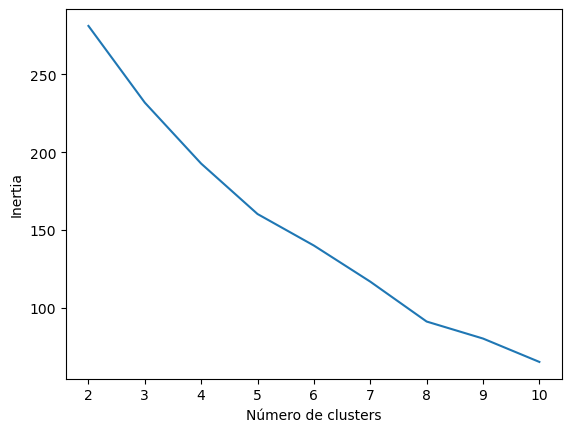

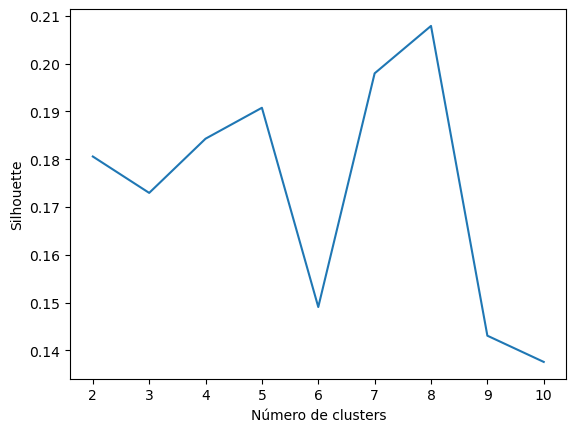

In [24]:
# hacemos un clustering con kmeans y representamos los clusters en 3D. No sabemos cuántos clusters hay. usaremos el método del codo para averiguarlo


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Vamos a probar con un número de clusters entre 2 y 10
n_clusters = range(2, 11)
inertia = []
silhouette = []

for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_scaled, kmeans.labels_))

plt.plot(n_clusters, inertia)
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.show()

plt.plot(n_clusters, silhouette)
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette')
plt.show()


In [25]:

# Vemos que el número óptimo de clusters es 5


kmeans = KMeans(n_clusters=5)
kmeans.fit(df_scaled)
df['Cluster'] = kmeans.labels_

df.head(19)

# Representamos los datos en 3D (debe poder girarse, usaremos plotly). Cada punto debe mostrar su nombre (distrito) y su cluster

fig = px.scatter_3d(x=df_pca[:, 0], y=df_pca[:, 1], z=df_pca[:, 2], text=df['Distrito'], color=df['Cluster'], width=1000, height=1000)

fig.show()


c:\Users\Carlo\anaconda3\envs\NLP_3.10\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Carlo\anaconda3\envs\NLP_3.10\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

